<a href="https://colab.research.google.com/github/MoBanerjee/InternshipAssignments/blob/main/Copy_of_Mohor_Polybee_Tech_Task_Automatic_Depth_Thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installations

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# assert torch.__version__.startswith("1.9")

# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html --quiet
# import detectron2
# from detectron2.utils.logger import setup_logger
# setup_logger()
# from detectron2 import model_zoo
# from detectron2.config import get_cfg
# from detectron2.utils.visualizer import Visualizer
# from detectron2.data import MetadataCatalog, DatasetCatalog

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

!pip3 install scikit-spatial
import skspatial

!pip3 install pickle5
import pickle5 as pickle
import imutils
import io
import sys

2.0.1+cu118 False
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Internal functions DO NOT MODIFY


In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
          return super().find_class(module, name)


def save_pickle(filepath, content):
    with open(filepath, 'wb') as pickle_file:
        pickle.dump(content, pickle_file, -1)


def load_pickle(filepath):
    with open(filepath, "rb") as input_file:
        annotations = CPU_Unpickler(input_file).load()
    return annotations


def mask_to_poly(mask):
    mask = np.array(mask).astype(np.uint8)
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts):
        c = max(cnts, key=cv2.contourArea)
    else:
        c = []
    return c


def poly_to_mask(polygon, im_shape):
    mask = np.zeros(im_shape)
    cv2.drawContours(mask, [polygon], -1, color=(255,255,255), thickness=-1)
    return mask.astype(bool)


def draw_annotation(image, bbox, polygon, thickness=2):
    top_left = (int(bbox[0]), int(bbox[1]))
    bot_right = (int(bbox[2]), int(bbox[3]))
    cv2.rectangle(image, top_left, bot_right, (239,255, 0), thickness)
    cv2.drawContours(image, polygon, -1, (0,255,255), thickness)

#Helper Functions, Use them to visualise the images, depthmaps and annotations

In [3]:
def load_annotation(annotation_filename):
    '''
    Load annotations file to use for labelling
    INPUTS
    annotation_filename (str or path): Path to the annotation file
    OUTPUTS
    annotations (Dict): A dictionary containing annotations
    '''
    annotations = load_pickle(annotation_filename)
    return annotations


def label_image(image, annotations):
    '''
    labels annotations (bbox and masks) on the given image
    INPUTS
    image (np.array): Image to be labelled
    annotations (dict): Annotation dictionary
    '''
    for idx, annotation in annotations.items():
        bbox = annotation['bbox']
        polygon = annotation['polygon']
        draw_annotation(image, bbox, polygon)


def draw_image(image):
    '''
    Resizes and draws images for visualisation
    INPUTS
    image (np.array) Image to be drawn
    '''
    res = cv2.resize(image, (270,480))
    cv2_imshow(res)


def color_depthmap(depth_map):
    '''
    To visualise the depthmap, the function colors it like a heatmap
    INPUTS
    depth_map (np.array): The depthmap to be colored
    OUTPUTS
    depth_colored (np.array): Colored depthmap
    '''
    depth_colored = cv2.applyColorMap(cv2.convertScaleAbs(depth_map, alpha=10), cv2.COLORMAP_JET)
    return depth_colored

## Mount images here

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


!unzip -q "/content/drive/MyDrive/Polybee/TaskDataset.zip"

Mounted at /content/drive/
replace TaskDataset/Test1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


##Example Data visualisation

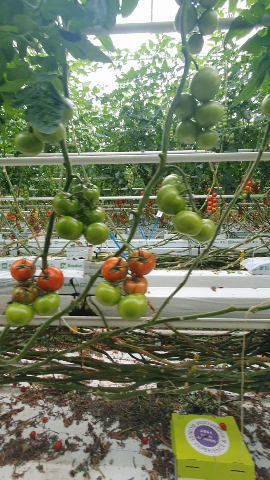

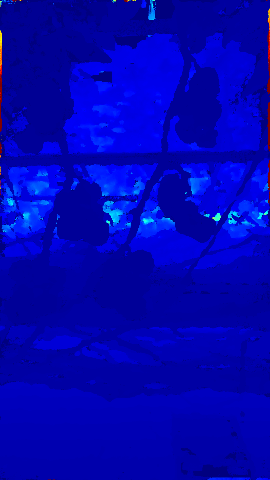

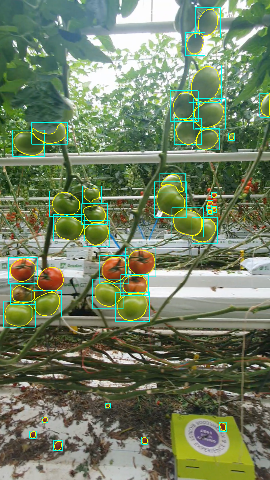

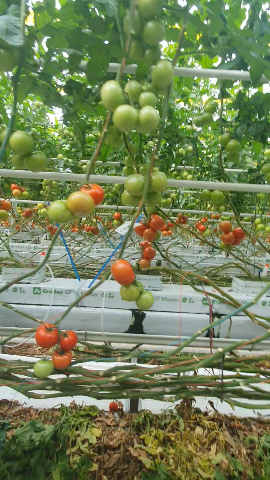

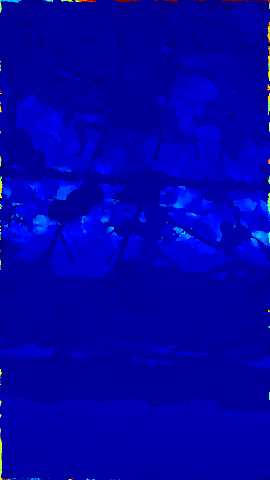

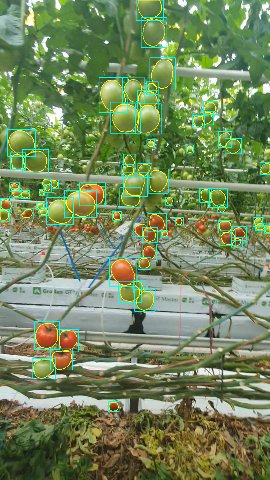

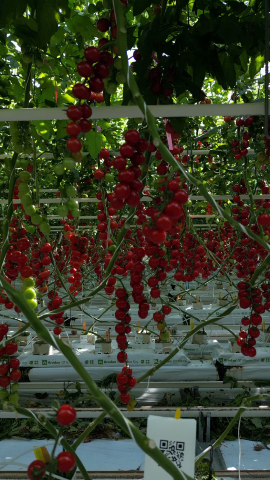

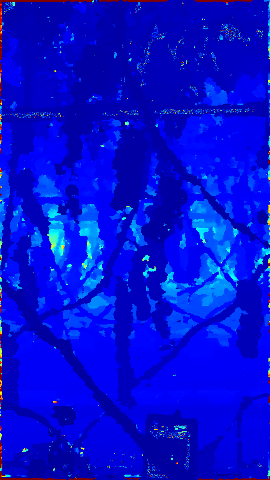

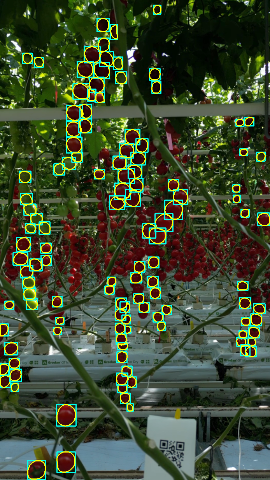

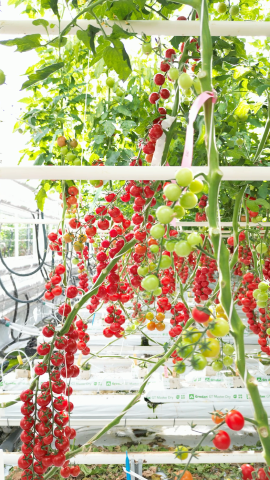

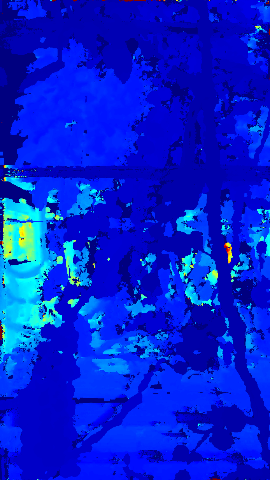

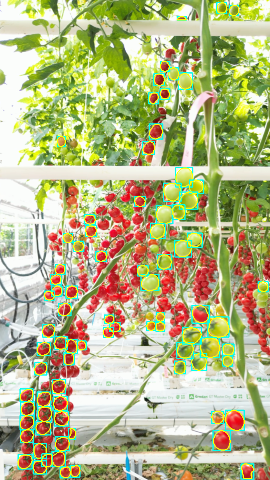

In [201]:
taskfolder = "/content/TaskDataset"
for filename in sorted([[f"{taskfolder}/{x[:-4]}", x[-4:]] for x in os.listdir(taskfolder) if x[-4:] == ".png" or x[-4:] == ".jpg"]):
  imagefile = f"{filename[0]}{filename[1]}"
  image = cv2.imread(imagefile)

  depthfile = f"{filename[0]}_depth.npy"

  depth = np.load(depthfile)

  annofile = f"{filename[0]}_annotation.pkl"
  anno = load_annotation(annofile)



  draw_image(image)
  colored_depth = color_depthmap(depth)

  draw_image(colored_depth)
  label_image(image, anno)
  draw_image(image)


Function to determine depth threshold automatically and only count foreground tomatoes

Function to determine tomato depth correctly even if tomato is occluded by a leaf or branch (mask could include leaf in tests used by us)

In [17]:
!pip install opencv-python --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 10.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [214]:
from sklearn.cluster import KMeans
import math
import numpy as np

def estimate_tomato_depth(annotation_dict, depth_map):
    # Extract relevant information from the annotation dictionary
    class_label = annotation_dict['class']
    mask = annotation_dict['polygon']
    bbox = annotation_dict['bbox']

    # Ensure the class label corresponds to a tomato (or the desired object)
    if class_label == 0:
        # Get the centroid of the tomato region
        mask = mask.reshape(-1, 2)
        centroid_x = int(np.mean([point[0] for point in mask]))
        centroid_y = int(np.mean([point[1] for point in mask]))
        if(centroid_y>=depth_map.shape[1]):
          centroid_y=depth_map.shape[1]-1
        centroid_depth=depth_map[centroid_x,centroid_y]
        return centroid_depth
        """

        print(bbox[1])
        # Extract the depth values from the depth map within the bounding box
        depth_region = depth_map[math.floor(bbox[1]):math.floor(bbox[1]+bbox[3]), math.floor(bbox[0]):math.floor(bbox[0]+bbox[2])]

        # Query depth values at the centroid
        centroid_depth = depth_region[math.floor(centroid_y - bbox[1]), math.floor(centroid_x - bbox[0])]
    """

    else:
        raise ValueError("The provided annotation is not for a tomato.")




In [208]:
def depth_threshold (img, depth, anno) :
  all_centroid_depths = []
  for annotation_dict,depth_map in zip(anno.values(), depth):

      centroid_depth = estimate_tomato_depth(annotation_dict, depth)
      all_centroid_depths.append(centroid_depth)

  # Convert the depths to a 2D array for KMeans clustering
  centroid_depths_array = np.array(all_centroid_depths).reshape(-1, 1)

  # Apply KMeans clustering
  num_clusters = 2  # Assuming you want to separate foreground and background tomatoes
  kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(centroid_depths_array)

  # Get the cluster centroids
  cluster_centroids = kmeans.cluster_centers_

  # The depth threshold is the midpoint between the cluster centroids
  depth_threshold = (cluster_centroids[0] + cluster_centroids[1]) / 2
  count=0;
  annonew={}
  imdup=image.copy()
  e=0
  for annotation_dict,depth_map in zip(anno.values(), depth):

      centroid_depth = estimate_tomato_depth(annotation_dict, depth)
      if(centroid_depth<=depth_threshold):
        count=count+1
        annonew[e]=annotation_dict
        e=e+1
  label_image(imdup,annonew)
  return depth_threshold,count,imdup
  # Now, depth_threshold can be used to separate foreground and background tomatoes

In [216]:
from sklearn.cluster import DBSCAN
import numpy as np

def depth_threshold(img, depth, anno):
    all_centroid_depths = []
    for annotation_dict, depth_map in zip(anno.values(), depth):
        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        all_centroid_depths.append(centroid_depth)

    # Convert the depths to a 2D array for DBSCAN clustering
    centroid_depths_array = np.array(all_centroid_depths).reshape(-1, 1)

    # Apply DBSCAN clustering
    eps = 0.1  # Maximum distance between two samples for one to be considered as in the neighborhood of the other
    min_samples = 5  # The number of samples in a neighborhood for a point to be considered as a core point
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(centroid_depths_array)

    # Assuming that label -1 corresponds to noise/outliers
    foreground_labels = np.where(labels != -1)[0]

    # Calculate depth threshold based on foreground points
    foreground_depths = centroid_depths_array[foreground_labels]
    depth_threshold = np.mean(foreground_depths)

    count = 0
    annonew={}
    imdup=image.copy()
    e=0
    for annotation_dict,depth_map in zip(anno.values(), depth):

        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        if(centroid_depth<=depth_threshold):
          count=count+1
          annonew[e]=annotation_dict
          e=e+1
    print(annonew.keys())
    label_image(imdup,annonew)
    return depth_threshold,count,imdup


In [218]:
from sklearn.mixture import GaussianMixture
import numpy as np

def depth_threshold(img, depth, anno):
    all_centroid_depths = []
    for annotation_dict, depth_map in zip(anno.values(), depth):
        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        all_centroid_depths.append(centroid_depth)

    # Convert the depths to a 2D array for GMM
    centroid_depths_array = np.array(all_centroid_depths).reshape(-1, 1)

    # Apply Gaussian Mixture Models (GMM)
    num_clusters = 2  # Assuming you want to separate foreground and background tomatoes
    gmm = GaussianMixture(n_components=num_clusters)
    gmm.fit(centroid_depths_array)
    labels = gmm.predict(centroid_depths_array)

    # Assuming that label 0 corresponds to the foreground cluster
    foreground_labels = np.where(labels == 0)[0]

    # Calculate depth threshold based on foreground points
    foreground_depths = centroid_depths_array[foreground_labels]
    depth_threshold = np.mean(foreground_depths)

    count = 0
    annonew={}
    imdup=image.copy()
    e=0
    for annotation_dict,depth_map in zip(anno.values(), depth):

        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        if(centroid_depth<=depth_threshold):
          count=count+1
          annonew[e]=annotation_dict
          e=e+1
    label_image(imdup,annonew)
    return depth_threshold,count,imdup

In [220]:
from sklearn.cluster import AffinityPropagation
import numpy as np

def depth_threshold(img, depth, anno):
    all_centroid_depths = []
    for annotation_dict, depth_map in zip(anno.values(), depth):
        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        all_centroid_depths.append(centroid_depth)

    # Convert the depths to a 2D array for Affinity Propagation
    centroid_depths_array = np.array(all_centroid_depths).reshape(-1, 1)

    # Apply Affinity Propagation clustering
    affinity_propagation = AffinityPropagation(damping=0.5)  # Adjust damping as needed
    labels = affinity_propagation.fit_predict(centroid_depths_array)

    # Assuming that label 0 corresponds to the foreground cluster
    foreground_labels = np.where(labels == 0)[0]

    # Calculate depth threshold based on foreground points
    foreground_depths = centroid_depths_array[foreground_labels]
    depth_threshold = np.mean(foreground_depths)

    count = 0
    annonew={}
    imdup=image.copy()
    e=0
    for annotation_dict,depth_map in zip(anno.values(), depth):

        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        if(centroid_depth<=depth_threshold):
          count=count+1
          annonew[e]=annotation_dict
          e=e+1
    print(annonew.keys())
    label_image(imdup,annonew)
    return depth_threshold,count,imdup

In [222]:
from sklearn.cluster import Birch
import numpy as np

def depth_threshold(img, depth, anno):
    all_centroid_depths = []
    for annotation_dict, depth_map in zip(anno.values(), depth):
        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        all_centroid_depths.append(centroid_depth)

    # Convert the depths to a 2D array for Birch clustering
    centroid_depths_array = np.array(all_centroid_depths).reshape(-1, 1)

    # Apply Birch clustering
    birch = Birch(n_clusters=2, threshold=0.1, branching_factor=50)  # Adjust parameters as needed
    labels = birch.fit_predict(centroid_depths_array)

    # Assuming that label 0 corresponds to the foreground cluster
    foreground_labels = np.where(labels == 0)[0]

    # Calculate depth threshold based on foreground points
    foreground_depths = centroid_depths_array[foreground_labels]
    depth_threshold = np.mean(foreground_depths)

    count = 0
    annonew={}
    imdup=image.copy()
    e=0
    for annotation_dict,depth_map in zip(anno.values(), depth):

        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        if(centroid_depth<=depth_threshold):
          count=count+1
          annonew[e]=annotation_dict
          e=e+1
    label_image(imdup,annonew)
    return depth_threshold,count,imdup


In [224]:
!pip install hdbscan
import numpy as np
import hdbscan

def depth_threshold(img, depth, anno):
    all_centroid_depths = []
    for annotation_dict, depth_map in zip(anno.values(), depth):
        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        all_centroid_depths.append(centroid_depth)

    # Convert the depths to a 2D array for HDBSCAN
    centroid_depths_array = np.array(all_centroid_depths).reshape(-1, 1)

    # Apply HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)  # Adjust parameters as needed
    labels = clusterer.fit_predict(centroid_depths_array)

    # Assuming that label -1 corresponds to noise/outliers
    foreground_labels = np.where(labels != -1)[0]

    # Calculate depth threshold based on foreground points
    foreground_depths = centroid_depths_array[foreground_labels]
    depth_threshold = np.mean(foreground_depths)

    count = 0
    annonew={}
    imdup=image.copy()
    e=0
    for annotation_dict,depth_map in zip(anno.values(), depth):

        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        if(centroid_depth<=depth_threshold):
          count=count+1
          annonew[e]=annotation_dict
          e=e+1
    label_image(imdup,annonew)
    return depth_threshold,count,imdup


In [226]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

def depth_threshold(img, depth, anno):
    all_centroid_depths = []
    for annotation_dict, depth_map in zip(anno.values(), depth):
        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        all_centroid_depths.append(centroid_depth)

    # Convert the depths to a 2D array for Agglomerative Clustering
    centroid_depths_array = np.array(all_centroid_depths).reshape(-1, 1)

    # Apply Agglomerative Clustering
    num_clusters = 2  # Assuming you want to separate foreground and background tomatoes
    agg_cluster = AgglomerativeClustering(n_clusters=num_clusters)
    labels = agg_cluster.fit_predict(centroid_depths_array)

    # Assuming that label 0 corresponds to the foreground cluster
    foreground_labels = np.where(labels == 0)[0]

    # Calculate depth threshold based on foreground points
    foreground_depths = centroid_depths_array[foreground_labels]
    depth_threshold = np.mean(foreground_depths)

    count = 0
    annonew={}
    imdup=image.copy()
    e=0
    for annotation_dict,depth_map in zip(anno.values(), depth):

        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        if(centroid_depth<=depth_threshold):
          count=count+1
          annonew[e]=annotation_dict
          e=e+1
    label_image(imdup,annonew)
    return depth_threshold,count,imdup


In [ ]:
def occ_tomato_depth (img, depth, anno) :
  #inputs : image, depth, segmented tomato polygons
  #outputs : list of tomatoes and their depths in m, image with area used for depth estimation marked

In [228]:
from sklearn.cluster import MeanShift
import numpy as np

def depth_threshold(img, depth, anno):
    all_centroid_depths = []
    for annotation_dict, depth_map in zip(anno.values(), depth):
        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        all_centroid_depths.append(centroid_depth)

    # Convert the depths to a 2D array for Mean Shift clustering
    centroid_depths_array = np.array(all_centroid_depths).reshape(-1, 1)

    # Apply Mean Shift clustering
    bandwidth = 0.1  # Bandwidth parameter for Mean Shift
    meanshift = MeanShift(bandwidth=bandwidth)
    labels = meanshift.fit_predict(centroid_depths_array)

    # Assuming that label 0 corresponds to the foreground cluster
    foreground_labels = np.where(labels == 0)[0]

    # Calculate depth threshold based on foreground points
    foreground_depths = centroid_depths_array[foreground_labels]
    depth_threshold = np.mean(foreground_depths)

    count = 0
    annonew={}
    imdup=image.copy()
    e=0
    for annotation_dict,depth_map in zip(anno.values(), depth):

        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        if(centroid_depth<=depth_threshold):
          count=count+1
          annonew[e]=annotation_dict
          e=e+1
    label_image(imdup,annonew)
    return depth_threshold,count,imdup

In [230]:
from sklearn.cluster import OPTICS
import numpy as np

def depth_threshold(img, depth, anno):
    all_centroid_depths = []
    for annotation_dict, depth_map in zip(anno.values(), depth):
        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        all_centroid_depths.append(centroid_depth)

    # Convert the depths to a 2D array for OPTICS clustering
    centroid_depths_array = np.array(all_centroid_depths).reshape(-1, 1)

    # Apply OPTICS clustering
    optics = OPTICS(min_samples=5)  # Adjust min_samples as needed
    labels = optics.fit_predict(centroid_depths_array)

    # Assuming that label -1 corresponds to noise/outliers
    foreground_labels = np.where(labels != -1)[0]

    # Calculate depth threshold based on foreground points
    foreground_depths = centroid_depths_array[foreground_labels]
    depth_threshold = np.mean(foreground_depths)

    count = 0
    annonew={}
    imdup=image.copy()
    e=0
    for annotation_dict,depth_map in zip(anno.values(), depth):

        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        if(centroid_depth<=depth_threshold):
          count=count+1
          annonew[e]=annotation_dict
          e=e+1
    label_image(imdup,annonew)
    return depth_threshold,count,imdup

In [232]:
from sklearn.cluster import SpectralClustering
import numpy as np

def depth_threshold(img, depth, anno):
    all_centroid_depths = []
    for annotation_dict, depth_map in zip(anno.values(), depth):
        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        all_centroid_depths.append(centroid_depth)

    # Convert the depths to a 2D array for Spectral Clustering
    centroid_depths_array = np.array(all_centroid_depths).reshape(-1, 1)

    # Apply Spectral Clustering
    num_clusters = 2  # Adjust as needed
    spectral_cluster = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', random_state=0)
    labels = spectral_cluster.fit_predict(centroid_depths_array)

    # Assuming that label 0 corresponds to the foreground cluster
    foreground_labels = np.where(labels == 0)[0]

    # Calculate depth threshold based on foreground points
    foreground_depths = centroid_depths_array[foreground_labels]
    depth_threshold = np.mean(foreground_depths)

    count = 0
    annonew={}
    imdup=image.copy()
    e=0
    for annotation_dict,depth_map in zip(anno.values(), depth):

        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        if(centroid_depth<=depth_threshold):
          count=count+1
          annonew[e]=annotation_dict
          e=e+1
    label_image(imdup,annonew)
    return depth_threshold,count,imdup

36.983616
34


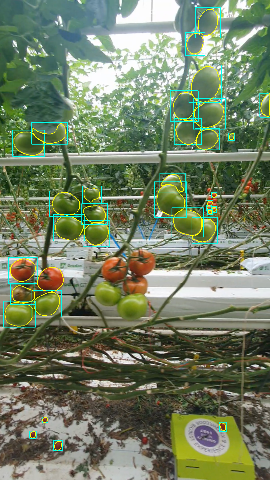

0.6938059
25


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


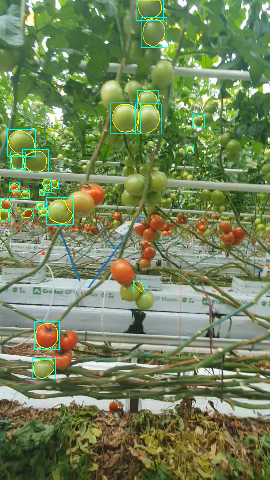

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


8.4502125
97


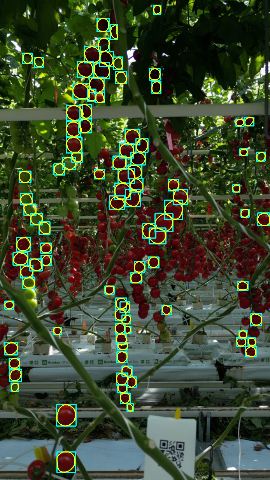

3.3489344
58


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


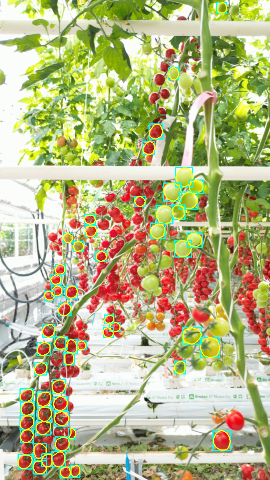

In [233]:
taskfolder = "/content/TaskDataset"
for filename in sorted([[f"{taskfolder}/{x[:-4]}", x[-4:]] for x in os.listdir(taskfolder) if x[-4:] == ".png" or x[-4:] == ".jpg"]):
  imagefile = f"{filename[0]}{filename[1]}"
  image = cv2.imread(imagefile)

  depthfile = f"{filename[0]}_depth.npy"
  depth = np.load(depthfile)

  annofile = f"{filename[0]}_annotation.pkl"
  anno = load_annotation(annofile)
  x,y,im=depth_threshold(image,depth,anno)
  print(x)
  print(y)
  draw_image(im)
